# Analyze the polymer regression learning curves


In [1]:
import matplotlib.pyplot as plt
from fastcore.utils import load_pickle
from glob import glob
import pandas as pd

plt.style.use(["science", "nature"])
colors = ["#0C5DA5", "#00B945", "#FF9500", "#FF2C00", "#845B97", "#474747", "#9e9e9e"]


In [2]:
all_res = glob(
    "/Users/kevinmaikjablonka/git/kjappelbaum/gpt3forchem/experiments/results/polymer_regression/*.pkl"
)


In [3]:
len(all_res)


62

In [4]:
def compile_data(file):
    res = load_pickle(file)
    model_type = res["model_type"]
    train_size = res["train_size"]
    prefix = res["prefix"]
    r2 = res["r2"]
    max_error = res["max_error"]
    mse = res["mean_squared_error"]
    mae = res["mean_absolute_error"]

    return {
        "model_type": model_type,
        "train_size": train_size,
        "prefix": prefix,
        "r2": r2,
        "max_error": max_error,
        "mse": mse,
        "mae": mae,
    }


In [5]:
compile_data(all_res[0])


{'model_type': 'ada',
 'train_size': 500,
 'prefix': '',
 'r2': 0.8973229646961669,
 'max_error': 1.5999999999999996,
 'mse': 0.9324999999999993,
 'mae': 0.7749999999999995}

In [6]:
all_results = [compile_data(run) for run in all_res]
all_results = pd.DataFrame(all_results)
aggregated = all_results.groupby(["model_type", "prefix", "train_size"]).agg(
    ["mean", "std"]
)


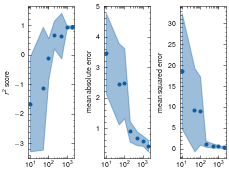

In [7]:
fig, ax = plt.subplots(1, 3, sharex="all")


ada_no_prefix = aggregated.loc["ada"].loc[""]
# ada_prefix = aggregated.loc["ada"].loc["I'm an expert polymer chemist "]

# davinci_no_prefix = aggregated.loc["davinci"].loc[""]
# davinci_prefix = aggregated.loc["davinci"].loc["I'm an expert polymer chemist "]

alpha = 0.4

for i, metric in enumerate(["r2", "mae", "mse"]):
    ax[i].scatter(
        ada_no_prefix.index,
        ada_no_prefix[metric]["mean"],
        label="ada, w/o prefix" if i == 0 else None,
        c=colors[0],
    )
    # ax[i].scatter(
    #     ada_prefix.index,
    #     ada_no_prefix[metric]["mean"],
    #     label="ada, w/ prefix" if i == 0 else None,
    #     c=colors[1],
    # )
    # ax[i].scatter(
    #     davinci_no_prefix.index,
    #     davinci_no_prefix[metric]["mean"],
    #     label="davinci, w/o prefix" if i == 0 else None,
    #     c=colors[2],
    # )
    # ax[i].scatter(
    #     davinci_prefix.index,
    #     davinci_prefix[metric]["mean"],
    #     label="davinci, w/ prefix" if i == 0 else None,
    #     c=colors[3],
    # )

    ax[i].fill_between(
        ada_no_prefix.index,
        ada_no_prefix[metric]["mean"] - ada_no_prefix[metric]["std"],
        ada_no_prefix[metric]["mean"] + ada_no_prefix[metric]["std"],
        color=colors[0],
        alpha=alpha,
        interpolate=True,
    )
    # ax[i].fill_between(
    #     ada_prefix.index,
    #     ada_no_prefix[metric]["mean"] - ada_no_prefix[metric]["std"],
    #     ada_no_prefix[metric]["mean"] + ada_no_prefix[metric]["std"],
    #     color=colors[1],
    #     alpha=alpha,
    #     interpolate=True,
    # )
    # ax[i].fill_between(
    #     davinci_no_prefix.index,
    #     davinci_no_prefix[metric]["mean"] - davinci_no_prefix[metric]["std"],
    #     davinci_no_prefix[metric]["mean"] + davinci_no_prefix[metric]["std"],
    #     color=colors[2],
    #     alpha=alpha,
    #     interpolate=True,
    # )
    # ax[i].fill_between(
    #     davinci_prefix.index,
    #     davinci_prefix[metric]["mean"] - davinci_prefix[metric]["std"],
    #     davinci_prefix[metric]["mean"] + davinci_prefix[metric]["std"],
    #     color=colors[3],
    #     alpha=alpha,
    #     interpolate=True,
    # )


ax[0].set_ylabel(r"$r^2$ score")
ax[1].set_ylabel(r"mean absolute error")
ax[2].set_ylabel(r"mean squared error")

# fig.legend(
#     bbox_to_anchor=(0.7, 1.1), ncol=2, handletextpad=0, labelspacing=0, columnspacing=0
# )
ax[0].set_xscale("log")
fig.tight_layout()
fig.savefig("polymer_regression_learning_curve.pdf", bbox_inches=False)


### Analyze error cases

Philippe highlighted plateaus in our scatter plots (https://github.com/kjappelbaum/gpt3forchem/issues/5). Let's look into those in some more detail. For this, we'll make interactive plots such that we can hoover.

In [18]:
import holoviews as hv
import pandas as pd 

In [17]:
load_pickle(all_res[1])['valid_filename']

'run_files/2022-08-23-22-28-20_valid_prompts_polymers_regression_2125.jsonl'

In [21]:
test_prompts = pd.read_json('run_files/2022-08-23-22-28-20_valid_prompts_polymers_regression_2125.jsonl', orient="records", lines=True)

In [14]:
completions = load_pickle(all_res[1])['completions']

In [13]:
from gpt3forchem.api_wrappers import extract_regression_prediction

In [15]:
predictions = [
    extract_regression_prediction(completions, i)
    for i, completion in enumerate(completions["choices"][0])
]


In [23]:
true = [
    float(test_prompts.iloc[i]["completion"].split("@")[0])
    for i in range(len(predictions))
]

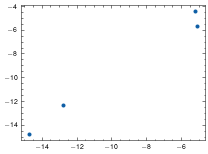

In [24]:
plt.scatter(true, predictions)